## Neural Networks for Novices
Prerequisites:
- Python experience, including a basing understanding of python syntax, loops, conditional statements, functions, and data types in python
- Some background in numerical computing - MATLAB, R, numpy, or similar, and an understanding of vectors, matrices, and relevant linear algebra concepts
- An understanding of model selection, train/test split, performance metrics and other concepts covered in the session on Classical Machine Learning

Goals for this session:
- Examine deep learning concepts such as tensors, tensor operations, gradient descent, and backpropagation
- Define and discuss hyperparameters in the context of deep learning models, including learning rate, batch size, epochs, layers, hidden units, optimizers, and activation functions
- Interpret loss and accuracy curves to identify overfitting during the training process
- Apply this knowledge to a real-world dataset using Tensorflow

Tensorflow documentation: [https://www.tensorflow.org/api_docs/python/tf](https://www.tensorflow.org/api_docs/python/tf)

Keras documentation: [https://www.tensorflow.org/guide/keras](https://www.tensorflow.org/guide/keras)

Tip: For faster training times, set your runtime to T4 GPU under `Runtime > Change runtime type`. Luckily, Tensorflow conveniently manages simple GPU use cases like this under the hood.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Set random seed
SEED = 100
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [3]:
# Google Colab
# DATA_PATH = "/content/datafiles"
# SAVE_PATH = "/content/models"


DATA_PATH = "/Users/trevoryu/Code/data/mnist"
SAVE_PATH = "/Users/trevoryu/Code/models/wat-ai"

# Obtain dataset
The dataset can be downloaded using Tensorflow datasets conveniently.

In [4]:
(train_dataset, val_dataset, test_dataset), ds_info = tfds.load(
    "mnist",
    split=["train[0:50_000]", "train[-10_000:]", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
    data_dir=DATA_PATH
)
list(map(len, [train_dataset, val_dataset, test_dataset]))

[50000, 10000, 10000]

In [5]:
x_plot, y_plot = tfds.load(
    "mnist",
    split="test[1000:1020]",
    shuffle_files=False,
    as_supervised=True,
    data_dir=DATA_PATH,
    batch_size=-1
)
# x_plot dtype is int8, scale between [0, 1] in float32 dtype for later
x_plot = x_plot / 255

In [6]:
# x_plot has shape (B, H, W, C)
x_plot.shape

TensorShape([20, 28, 28, 1])

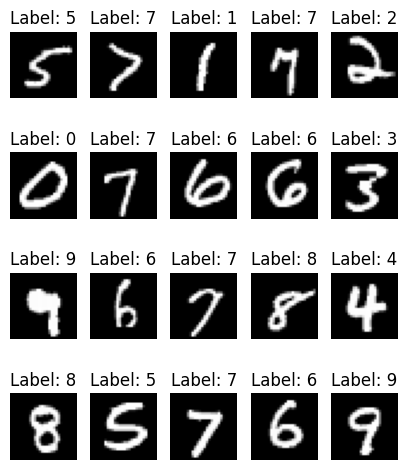

Each image is a tf.Tensor and has shape (28, 28, 1).
The labels are the integers 0 to 9, representing the digits.


In [7]:
fig, axs = plt.subplots(4, 5, figsize=(5, 6))

plot_images = []
plot_labels = []

for ax, image, label in zip(axs.flatten(), x_plot, y_plot):
    # Save this data for later
    plot_images.append(tf.expand_dims(image, 0))
    plot_labels.append(label)

    # Plot each image
    ax.imshow(tf.squeeze(image), cmap="gray")
    ax.set_title(f"Label: {label}")
    ax.axis("off")
plt.show()

plot_images = tf.concat(plot_images, axis=0)  # Combine all the images into a single batch for later

print(f"Each image is a tf.Tensor and has shape {image.shape}.")
print(f"The labels are the integers 0 to 9, representing the digits.")

# Convert data into tensors
Loading from `tfds` already returns tensors, so if your data comes from other sources, you would need to do this. However, our data comes in `uint8` datatype, but most neural networks expect `float32`. Additionally, neural networks prefer data that comes from a random normal distribution, or scaled to between [-1, 1] or [0, 1]. We can scale the data easily to [0, 1] by dividing by 255, the maximum value of a `uint8`.

In [8]:
def preprocess(x, y):
    """
    Preprocess input data to neural network
    :param x: tf.Tensor image batch, of shape (B, 28, 28, 1)
    :param y: tf.Tensor labels, of shape (B,)

    :returns: (x, y), processed inputs of shapes ((B, 784), (B,))
    """
    # Rescale the data
    x = x / 255
    return x, y

In [9]:
# Apply the preprocessing to all the datasets
train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

# Define model architecture
Conveniently, Keras allows us to define a model as a sequence of layers. For a simple multi-layer perceptron, this is perfect, although more complex architectures can be made too using a similar API to PyTorch (come to Dive Into Deep Learning to learn more!). Keras also has a `Dense` layer that implements both the linear weight matrix, additive bias, and activation into one layer. Since the multi-layer perceptron is built of these three things, we can just use `Dense` layers. Note that since our inputs come in shape (28, 28, 1), we should flatten them first to a vector of length (784,) before passing them to the `Dense` layers.

Note that the output of the model will the log odds (or logits) of predicting each of the 10 classes. The index of the output with the highest probability is the class that would be selected.

In [10]:
model = keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(2048, activation="relu"),  # Dense layer of 2048 units
    tf.keras.layers.Dense(512, activation="relu"),  # Dense layer of 512 units
    tf.keras.layers.Dense(128, activation="relu"),  # Dense layer of 128 units
    tf.keras.layers.Dense(10)  # Output layer, 10 units, no activation
])

In [11]:
# Test our model on the plotting datapoints. The output should be shape (B, n_classes) = (20, 10)
logits = model(x_plot)
logits.shape

TensorShape([20, 10])

# Select hyperparameters
We'll use a batch size of 128, train for 20 epochs, and use an optimizer learning rate of 1e-3.

In [12]:
BATCH_SIZE = 128
EPOCHS = 20
LEARNING_RATE = 1e-3

AUTOTUNE = tf.data.AUTOTUNE

For the loss function, `SparseCategoricalCrossentropy(from_logits=True)` implements softmax efficiently in the loss calculation, so we don't need to include a final softmax activation in the last layer. The corresponding metric for this classification problem is `SparseCategoricalAccuracy`. 

For the optimizer, `Adam` is a typical default deep learning optimizer and is a good starting point for many problems.

For the datasets, we need to batch and shuffle the training dataset. For the validation and test datasets, we don't need to shuffle, but we should still batch them.

In [13]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

train_dataset = train_dataset.cache().shuffle(buffer_size=train_dataset.cardinality(), seed=SEED).batch(BATCH_SIZE).prefetch(AUTOTUNE)

val_dataset = val_dataset.cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)

To verify, we can compute the loss over the test images we showed earlier


In [14]:
loss_function(y_plot, logits)

<tf.Tensor: shape=(), dtype=float32, numpy=2.3144119>

In Tensorflow, we compile the model with the optimizer, loss, and metrics


In [15]:
model.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=metrics
)

Tensorflow has a convient training API with the `fit` method

In [16]:
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset
)

Epoch 1/20
391/391 [==============================] - 7s 15ms/step - loss: 0.2121 - sparse_categorical_accuracy: 0.9345 - val_loss: 0.1179 - val_sparse_categorical_accuracy: 0.9642
Epoch 2/20
391/391 [==============================] - 6s 16ms/step - loss: 0.0793 - sparse_categorical_accuracy: 0.9757 - val_loss: 0.0944 - val_sparse_categorical_accuracy: 0.9714
Epoch 3/20
391/391 [==============================] - 6s 16ms/step - loss: 0.0533 - sparse_categorical_accuracy: 0.9824 - val_loss: 0.0913 - val_sparse_categorical_accuracy: 0.9741
Epoch 4/20
391/391 [==============================] - 6s 15ms/step - loss: 0.0411 - sparse_categorical_accuracy: 0.9865 - val_loss: 0.0863 - val_sparse_categorical_accuracy: 0.9768
Epoch 5/20
391/391 [==============================] - 6s 15ms/step - loss: 0.0320 - sparse_categorical_accuracy: 0.9895 - val_loss: 0.0998 - val_sparse_categorical_accuracy: 0.9710
Epoch 6/20
391/391 [==============================] - 6s 15ms/step - loss: 0.0289 - sparse_cate

The `history` object returned from `model.fit()` contains a lot of metrics that Tensorflow automatically records. We can plot them to visualize the training curves and see how well the model fit.

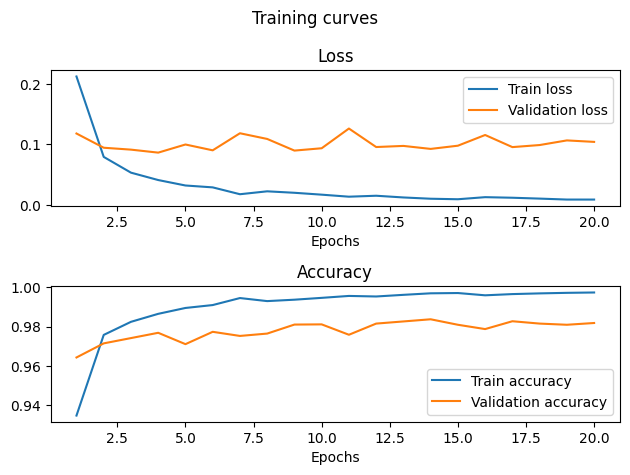

In [17]:
fig, axs = plt.subplots(2, 1)

labels = {
    "loss": "Train loss",
    "sparse_categorical_accuracy": "Train accuracy",
    "val_loss": "Validation loss",
    "val_sparse_categorical_accuracy": "Validation accuracy"
}

epochs = np.arange(EPOCHS) + 1

for key, metric in history.history.items():
    if "loss" in key:
        epochs = np.arange(len(metric)) + 1
        axs[0].plot(epochs, metric, label=labels[key])
    else:
        axs[1].plot(epochs, metric, label=labels[key])

for ax in axs:
    ax.legend()
    ax.set_xlabel("Epochs")

axs[0].set_title("Loss")
# axs[0].set_ylim(-0.05, 0.5)
axs[1].set_title("Accuracy")
plt.suptitle("Training curves")
plt.tight_layout()
plt.show()

The model seems to have overfit by the end of 20 epochs. The validation loss is going up, and the accuracy is fluctuating. The model's performance is a little based on chance, depending on where it was after the 20 epochs.

# Evaluate on the test set

We should always test our model on the testing dataset. Especially if we do hyperparameter tuning, it is not sufficient to just use two datasets, since we might adjust hyperparameters that best fit the validation data, but not some other realworld / held out data.

If we have labels, we can score the model with `model.evaluate()`.

In [18]:
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Test loss: {test_loss:.3f}")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

79/79 [==============================] - 0s 5ms/step - loss: 0.0959 - sparse_categorical_accuracy: 0.9809
Test loss: 0.096
Test accuracy: 98.09%


If we only have inputs, then we should use `model.predict()` instead. Remember that the model returns log probability scores (logits). So to obtain the class, we should use `argmax` to find the index of the most likely (highest probability) output neuron.

In [19]:
logits = model.predict(x_plot)
y_pred = logits.argmax(axis=-1)

1/1 [==============================] - 0s 52ms/step


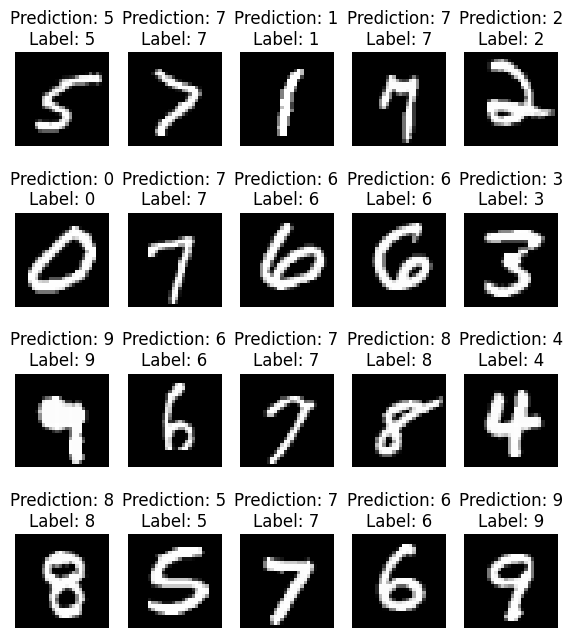

In [20]:
# Plot and show the labels
fig, axs = plt.subplots(4, 5, figsize=(7, 8))

for ax, image, label, pred in zip(axs.flatten(), x_plot, y_plot, y_pred):
    # Plot each image
    ax.imshow(tf.squeeze(image), cmap="gray")
    ax.set_title(f"Prediction: {pred}\nLabel: {label}")
    ax.axis("off")
plt.show()

# How to stop the model from overfitting?

In the Dive into Deep Learning session, we'll talk more about "regularization," which are techniques to stop from overfitting. But one easy one to use in Tensorflow is early stopping. Early stopping allows us to try to stop training before we get to overfitting. We can save a version of the model's parameters and load that for testing.

We can implement early stopping and model checkpointing with callbacks. These are functions that are called at certain points in the training loop. Our callbacks, in particular, will be called at the end of each epoch. Depending on the performance of the model, the training procedure might stop and a version of the model's parameters might be saved.

For early stopping, we need to pick a metric to monitor. We can also specify how long after the "best" observation of that metric we should wait until we call it quits.

For model checkpointing, we also need to specify a metric to monitor. We can also specify whether to save all models, or just the best model.

In [21]:
# Reset seed
tf.random.set_seed(SEED)

In [22]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_sparse_categorical_accuracy", patience=3),
    tf.keras.callbacks.ModelCheckpoint(SAVE_PATH, monitor="val_sparse_categorical_accuracy", save_best_only=True)
]

In [23]:
# Make a new model and train it
model = keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(2048, activation="relu"),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(10)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=metrics
)

In [24]:
history = model.fit(
    train_dataset, 
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/20
391/391 [==============================] - ETA: 0s - loss: 0.2082 - sparse_categorical_accuracy: 0.9442INFO:tensorflow:Assets written to: /Users/trevoryu/Code/models/wat-ai/assets


INFO:tensorflow:Assets written to: /Users/trevoryu/Code/models/wat-ai/assets


391/391 [==============================] - 7s 18ms/step - loss: 0.2082 - sparse_categorical_accuracy: 0.9442 - val_loss: 0.1095 - val_sparse_categorical_accuracy: 0.9678
Epoch 2/20
389/391 [============================>.] - ETA: 0s - loss: 0.0860 - sparse_categorical_accuracy: 0.9734INFO:tensorflow:Assets written to: /Users/trevoryu/Code/models/wat-ai/assets


INFO:tensorflow:Assets written to: /Users/trevoryu/Code/models/wat-ai/assets


391/391 [==============================] - 7s 17ms/step - loss: 0.0858 - sparse_categorical_accuracy: 0.9734 - val_loss: 0.0962 - val_sparse_categorical_accuracy: 0.9728
Epoch 3/20
390/391 [============================>.] - ETA: 0s - loss: 0.0525 - sparse_categorical_accuracy: 0.9834INFO:tensorflow:Assets written to: /Users/trevoryu/Code/models/wat-ai/assets


INFO:tensorflow:Assets written to: /Users/trevoryu/Code/models/wat-ai/assets


391/391 [==============================] - 6s 16ms/step - loss: 0.0525 - sparse_categorical_accuracy: 0.9834 - val_loss: 0.0909 - val_sparse_categorical_accuracy: 0.9731
Epoch 4/20
390/391 [============================>.] - ETA: 0s - loss: 0.0400 - sparse_categorical_accuracy: 0.9869INFO:tensorflow:Assets written to: /Users/trevoryu/Code/models/wat-ai/assets


INFO:tensorflow:Assets written to: /Users/trevoryu/Code/models/wat-ai/assets


391/391 [==============================] - 6s 15ms/step - loss: 0.0400 - sparse_categorical_accuracy: 0.9869 - val_loss: 0.0793 - val_sparse_categorical_accuracy: 0.9773
Epoch 5/20
391/391 [==============================] - 6s 15ms/step - loss: 0.0336 - sparse_categorical_accuracy: 0.9891 - val_loss: 0.0877 - val_sparse_categorical_accuracy: 0.9756
Epoch 6/20
390/391 [============================>.] - ETA: 0s - loss: 0.0265 - sparse_categorical_accuracy: 0.9915INFO:tensorflow:Assets written to: /Users/trevoryu/Code/models/wat-ai/assets


INFO:tensorflow:Assets written to: /Users/trevoryu/Code/models/wat-ai/assets


391/391 [==============================] - 6s 15ms/step - loss: 0.0265 - sparse_categorical_accuracy: 0.9915 - val_loss: 0.0835 - val_sparse_categorical_accuracy: 0.9789
Epoch 7/20
391/391 [==============================] - 6s 15ms/step - loss: 0.0229 - sparse_categorical_accuracy: 0.9928 - val_loss: 0.0962 - val_sparse_categorical_accuracy: 0.9783
Epoch 8/20
391/391 [==============================] - ETA: 0s - loss: 0.0194 - sparse_categorical_accuracy: 0.9938INFO:tensorflow:Assets written to: /Users/trevoryu/Code/models/wat-ai/assets


INFO:tensorflow:Assets written to: /Users/trevoryu/Code/models/wat-ai/assets


391/391 [==============================] - 6s 15ms/step - loss: 0.0194 - sparse_categorical_accuracy: 0.9938 - val_loss: 0.0853 - val_sparse_categorical_accuracy: 0.9812
Epoch 9/20
391/391 [==============================] - 6s 15ms/step - loss: 0.0197 - sparse_categorical_accuracy: 0.9935 - val_loss: 0.0941 - val_sparse_categorical_accuracy: 0.9760
Epoch 10/20
391/391 [==============================] - 5s 14ms/step - loss: 0.0162 - sparse_categorical_accuracy: 0.9945 - val_loss: 0.1069 - val_sparse_categorical_accuracy: 0.9752
Epoch 11/20
391/391 [==============================] - 6s 14ms/step - loss: 0.0149 - sparse_categorical_accuracy: 0.9957 - val_loss: 0.1189 - val_sparse_categorical_accuracy: 0.9740


Best val accuracy: 98.120%


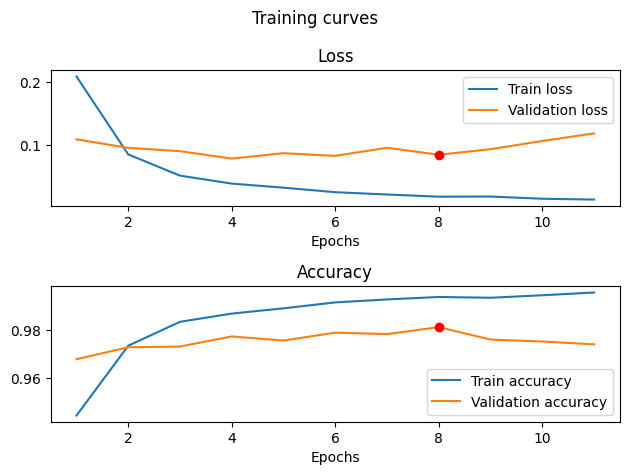

In [25]:
# Re-plot the training curves
fig, axs = plt.subplots(2, 1)

labels = {
    "loss": "Train loss",
    "sparse_categorical_accuracy": "Train accuracy",
    "val_loss": "Validation loss",
    "val_sparse_categorical_accuracy": "Validation accuracy"
}

epochs = np.arange(EPOCHS) + 1
best_ind = np.argmax(history.history["val_sparse_categorical_accuracy"])
best_acc = history.history["val_sparse_categorical_accuracy"][best_ind]
best_loss = history.history["val_loss"][best_ind]

for key, metric in history.history.items():
    if "loss" in key:
        epochs = np.arange(len(metric)) + 1
        axs[0].plot(epochs, metric, label=labels[key])
    else:
        axs[1].plot(epochs, metric, label=labels[key])

axs[0].plot(epochs[best_ind], best_loss, "ro")
axs[1].plot(epochs[best_ind], best_acc, "ro")

for ax in axs:
    ax.legend()
    ax.set_xlabel("Epochs")


axs[0].set_title("Loss")
# axs[0].set_ylim(-0.05, 0.5)
axs[1].set_title("Accuracy")
plt.suptitle("Training curves")
plt.tight_layout()

print(f"Best val accuracy: {best_acc*100:.3f}%")
plt.show()

We can see that the model stopped traiing at epoch 7 when the validation accuracy was the highest and it didn't improve for the following 3 epochs. We should load this model checkpoint and check its performance.

In [26]:
# Evaluate on test set with best model
best_model = tf.keras.models.load_model(SAVE_PATH)
checkpoint_test_loss, checkpoint_test_accuracy = best_model.evaluate(test_dataset)

print(f"Test loss, best model: {checkpoint_test_loss:.3f}")
print(f"Test accuracy, best model: {checkpoint_test_accuracy*100:.2f}%")

print(f"Test loss, old model: {test_loss:.3f}")
print(f"Test accuracy, old model: {test_accuracy*100:.2f}%")

79/79 [==============================] - 0s 3ms/step - loss: 0.0822 - sparse_categorical_accuracy: 0.9801
Test loss, best model: 0.082
Test accuracy, best model: 98.01%
Test loss, old model: 0.096
Test accuracy, old model: 98.09%


Early stopping helped to improve our held-out test set accuracy. In the activity, you can try to manually adjust other hyperparameters to see if you can get the performance to improve!